In [1]:
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import copy
from collections import deque
from skactiveml.classifier import PWC
from skactiveml.stream import RandomSampler, PeriodicSampler
from skactiveml.stream import FixedUncertainty, VariableUncertainty, Split
from skactiveml.stream.budget_manager import FixedBudget

In [3]:
random_state = np.random.RandomState(0)

In [4]:
init_train_length = 10
stream_length = 10000
training_size = 1000

In [5]:
def get_randomseed(random_state):
    random_state.randint(2**31-1)

In [6]:
X, y = sklearn.datasets.make_classification(n_samples=init_train_length + stream_length, random_state=get_randomseed(random_state), shuffle=True)
X_init = X[:init_train_length, :]
y_init = y[:init_train_length]
X_stream = X[init_train_length:, :]
y_stream = y[init_train_length:]

In [7]:
clf = PWC()
query_strategies = {
    'RandomSampler': RandomSampler(random_state=get_randomseed(random_state)),
    'PeriodicSampler': PeriodicSampler(random_state=get_randomseed(random_state)),
    'FixedUncertainty': FixedUncertainty(clf=clf, random_state=get_randomseed(random_state)),
    'VariableUncertainty': VariableUncertainty(clf=clf, random_state=get_randomseed(random_state)),
    'Split': Split(clf=clf, random_state=get_randomseed(random_state))
}

0.8327 RandomSampler
0.8393 PeriodicSampler
0.8986 FixedUncertainty
0.9008 VariableUncertainty
0.9003 Split


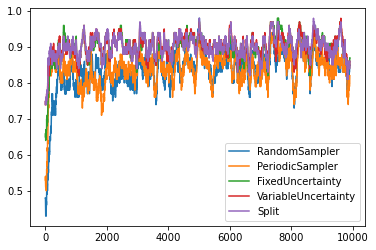

In [8]:
for query_strategy_name, query_strategy in query_strategies.items():
    X_train = deque(maxlen=training_size)
    X_train.extend(X_init)
    y_train = deque(maxlen=training_size)
    y_train.extend(y_init)
    clf.fit(X_train, y_train)
    correct_classifications = []
    for t, (x_t, y_t) in enumerate(zip(X_stream, y_stream)):
        correct_classifications.append(clf.predict(x_t.reshape([1, -1]))[0] == y_t)
        sampled_indices = query_strategy.query(x_t.reshape([1, -1]), X=None, y=None)
        if len(sampled_indices):
            X_train.append(x_t)
            y_train.append(y_t)
            clf.fit(X_train, y_train)
    print(np.sum(correct_classifications)/stream_length, query_strategy_name)
    cumsum_correct_classifications = np.cumsum(correct_classifications)
    smoothing_window_length = 100
    plt.plot((cumsum_correct_classifications[smoothing_window_length:]-cumsum_correct_classifications[:-smoothing_window_length])/smoothing_window_length, label=query_strategy_name)
plt.legend()